<a href="https://colab.research.google.com/github/nischitabiradar/BDA-696-Project---Fashion-Product-Classification-and-Recommendation/blob/main/Final_URL_recommendation_with_UI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install flask flask_ngrok

In [2]:
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok

In [9]:
# Step 1: Writing the requirements to a file
with open('requirements.txt', 'w') as file:
    file.write('swifter\n')
    file.write('torchvision\n')
    file.write('opencv-python\n')

# Step 2: Installing the libraries using the requirements.txt file
!pip install -r requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=2ebbd8aa27fbddf040cc16f37fb33e586a6a6cdc34e71ec6dc2b8a7325b7738f
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [10]:
import os
import cv2
import torch
import joblib
import numpy as np
import pandas as pd
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn as nn
from pandas.core.common import flatten
import torchvision.transforms as transforms
from torch.autograd import Variable
import warnings
import torchvision.models as models

plt.style.use('ggplot')
warnings.filterwarnings("ignore")


In [11]:
from pathlib import Path

# Defining the dataset path
DATASET_PATH = Path('/content/myntradataset')

# Listing the contents of the directory
print([item.name for item in DATASET_PATH.iterdir()])


['images', 'styles.csv']


In [12]:
from pathlib import Path
import pandas as pd

# Defining the dataset path
DATASET_PATH = Path('/content/myntradataset')

# Check if the styles.csv file exists in the directory
csv_file = DATASET_PATH / 'styles.csv'
if csv_file.is_file():
    try:
        # Read the CSV file
        df = pd.read_csv(csv_file, nrows=5000)
    except pd.errors.ParserError as e:
        print(f"Error while reading the CSV file: {e}")
else:
    print(f"The file {csv_file} does not exist.")

df.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [13]:
import pandas as pd

# Assuming df is your DataFrame and DATASET_PATH is defined
# Add a new column 'image' to the DataFrame with the constructed image filenames
df['image'] = df['id'].astype(str) + '.jpg'

# Display the first few rows of the DataFrame
df.head(5)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


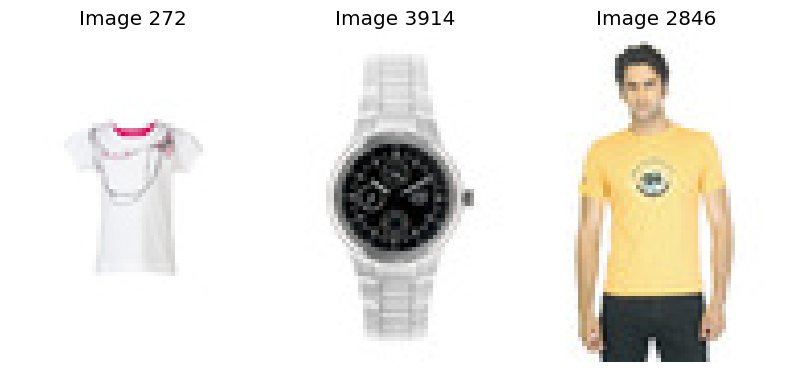

In [19]:
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Assuming DATASET_PATH is defined as before
DATASET_PATH = Path('/content/myntradataset/')

def get_image_path(filename):
    """Generate the full path for an image file."""
    return DATASET_PATH / 'images' / filename

def load_image(filename):
    """Load an image from a given filename."""
    path = get_image_path(filename)
    return cv2.imread(str(path))

def show_images_grid(images_dict, rows=2, cols=3, grid_size=(8, 8)):
    """Display a grid of images."""
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=grid_size)
    for index, (title, img) in enumerate(images_dict.items()):
        if img is not None:
            axes.ravel()[index].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes.ravel()[index].set_title(title)
        axes.ravel()[index].axis('off')
    plt.tight_layout()

# Generation of a dictionary of (title, image)
images_info = {f'Image {i}': load_image(row.image) for i, row in df.sample(3).iterrows()}

# Plot of the images in a figure, with 2 rows and 3 columns
show_images_grid(images_info, rows=1, cols=3)


In [20]:
# Desired dimensions for images
image_width, image_height = 224, 224

# Loading the pre-trained ResNet model
pretrained_resnet = models.resnet18(pretrained=True)

# Selecting the desired layer from the model
selected_layer = pretrained_resnet._modules.get('avgpool')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


In [21]:
#evaluate the model
pretrained_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
from torchvision import transforms

# scaling, normalizing, and tensor conversion
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Scaling the data
    transforms.ToTensor(),          # Converting to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalizing
                         std=[0.229, 0.224, 0.225])
])


In [23]:
from PIL import Image
from torch.autograd import Variable

# Global variables for transformations and missing images list
global image_transforms
global missing_img

# Function to get embeddings
def modified_vector_extraction(pretrained_resnet, image_id):
    try:
        # Load the image with Pillow library
        img = Image.open(get_image_path(image_id)).convert('RGB')

        # Apply the predefined transformations
        t_img = Variable(image_transforms(img).unsqueeze(0))

        # Create a vector of zeros that will hold our feature vector
        # The 'avgpool' layer has an output size of 512
        embeddings = torch.zeros(512)

        # Define a function that will copy the output of a layer
        def copy_data(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))

        # Attach that function to our selected layer
        hlayer = pretrained_resnet.avgpool.register_forward_hook(copy_data)

        # Run the model on our transformed image
        pretrained_resnet(t_img)

        # Detach our copy function from the layer
        hlayer.remove()

        return embeddings

    # If file not found
    except FileNotFoundError:
        print(f"File not found for image ID: {image_id}")
        missing_img.append(image_id)
        return None


In [25]:
from torchvision import models
from PIL import Image
from torch.autograd import Variable

# Function to modify the ResNet model
def modify_resnet_model(model):
    # Remove the last fully connected layer (fc) to get features from the avgpool layer
    model = nn.Sequential(*list(model.children())[:-1])
    return model

# Function to extract features
def extract_features_modified_model(modified_model, transformations, image_id):
    try:
        # Load the image with Pillow library
        img = Image.open(get_image_path(image_id)).convert('RGB')

        # Apply transformations
        transformed_img = Variable(transformations(img).unsqueeze(0))

        # Forward pass through the modified model
        modified_model.eval()
        with torch.no_grad():
            # Get the output directly from the modified model
            features = modified_model(transformed_img)

            # Flatten the features to a 1D vector
            features_vector = features.view(features.size(0), -1)

        return features_vector.numpy().flatten()

    except FileNotFoundError:
        print(f"File not found for image ID: {image_id}")
        return None




In [26]:
%%time
import swifter

# Applying embeddings on subset of this huge dataset
df_embeddings = df  # We can apply on the entire df, like: df_embeddings = df

# Define the modified ResNet model
modified_resnet = modify_resnet_model(models.resnet18(pretrained=True))

# Looping through images to get embeddings
map_embeddings = df_embeddings['image'].swifter.apply(lambda img: extract_features_modified_model(modified_resnet, image_transforms, img))

# Convert to a DataFrame
df_embs = pd.DataFrame(map_embeddings.tolist())

# Print the shape and the first few rows of the DataFrame
print(df_embs.shape)
df_embs.head()


Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 512)
CPU times: user 6min 26s, sys: 2.25 s, total: 6min 29s
Wall time: 6min 42s


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.018092,1.042106,0.030759,0.106612,0.248215,1.314161,0.070166,0.269750,1.374099,0.434485,...,0.663422,0.474600,1.207340,0.723219,0.000000,0.037897,1.661622,0.838834,0.006767,0.024396
1,0.034120,0.804466,0.071094,0.286108,0.118644,0.485673,0.767112,0.116924,1.131223,1.229429,...,0.125503,0.554489,0.160279,0.211642,0.000000,0.921632,1.210377,0.750111,0.015514,0.182357
2,0.306779,0.196792,2.325821,0.337870,0.206403,0.410262,2.865741,0.493548,2.894565,3.824199,...,0.377006,3.216578,2.293663,1.343938,1.047548,0.016881,2.759720,0.630301,0.114623,0.002224
3,0.052566,0.312827,0.318464,0.045759,0.207993,0.486138,0.871358,0.437959,0.861974,1.257671,...,0.000402,0.126219,0.117900,0.174460,0.000000,0.004943,1.039022,0.150582,0.009435,0.015908
4,0.146032,0.624986,0.023858,0.201499,0.273301,2.073839,0.038832,0.537266,1.338016,0.428539,...,0.039452,1.069757,0.774632,0.874318,0.000000,0.010583,2.638507,0.303630,0.005840,0.026666


In [27]:
from pathlib import Path

# Specify the directory path
directory_path = Path('/content/working')

# Create the directory
directory_path.mkdir(parents=True, exist_ok=True)

# List the contents of the current working directory to verify
print(list(Path('/content').iterdir()))


[PosixPath('/content/.config'), PosixPath('/content/kaggle (1).json'), PosixPath('/content/myntradataset'), PosixPath('/content/fashion-product-images-small.zip'), PosixPath('/content/requirements.txt'), PosixPath('/content/working'), PosixPath('/content/images'), PosixPath('/content/styles.csv'), PosixPath('/content/sample_data')]


In [28]:

# Specify the directory path
directory_path = Path('/content/working')

# Create the directory if it doesn't exist
directory_path.mkdir(parents=True, exist_ok=True)

# Specify the CSV file path
csv_file_path = directory_path / 'df_embs.csv'

# Export the embeddings to the CSV file
df_embs.to_csv(csv_file_path, index=False)



In [29]:
# Specify the CSV file path
csv_file_path = directory_path / 'df_embs.csv'

# Check if the CSV file exists
if csv_file_path.exists():
    # Read the embeddings from the CSV file
    df_embs = pd.read_csv(csv_file_path)
    df_embs.dropna(inplace=True)
    df_embs.reset_index(drop=True, inplace=True)
else:
    print(f"CSV file {csv_file_path} does not exist.")


In [30]:
import pickle


# Specify the directory path
directory_path = Path('/content/working')

# Create the directory if it doesn't exist
directory_path.mkdir(parents=True, exist_ok=True)

# Specify the pickle file path
pkl_file_path = directory_path / 'df_embs.pkl'

# Export the DataFrame as a pickle file
with open(pkl_file_path, 'wb') as pkl_file:
    pickle.dump(df_embs, pkl_file, protocol=4)


In [31]:
# Specify the pickle file path
pkl_file_path = directory_path / 'df_embs.pkl'

# Check if the pickle file exists
if pkl_file_path.exists():
    # Load the DataFrame from the pickle file
    with open(pkl_file_path, 'rb') as pkl_file:
        df_embs = pickle.load(pkl_file)
else:
    print(f"Pickle file {pkl_file_path} does not exist.")


In [32]:
# Calculating similarity between images ( using embedding values )
cosine_sim = cosine_similarity(df_embs)

# Previewing first 4 rows and 4 columns similarity just to check the structure of cosine_sim
cosine_sim[:4, :4]

array([[1.        , 0.76400116, 0.54799321, 0.77531746],
       [0.76400116, 1.        , 0.49617084, 0.88492659],
       [0.54799321, 0.49617084, 1.        , 0.52310666],
       [0.77531746, 0.88492659, 0.52310666, 1.        ]])

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix for all embeddings
cosine_sim = cosine_similarity(df_embs)

def recommend_images(image_index, df, top_n=6):
    # Get the cosine similarities of the specified image index with all other images
    sim_scores = list(enumerate(cosine_sim[image_index]))

    # Sort the similarities in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Extract the top n similar image indices (excluding the specified image itself)
    top_similar_indices = [i[0] for i in sim_scores[1:top_n+1]]

    # Extract the similarity scores
    similarity_scores = [i[1] for i in sim_scores[1:top_n+1]]

    # Map the similar indices to the original DataFrame index
    similar_image_indices = df.index[top_similar_indices]

    return similar_image_indices, similarity_scores

# Sample usage
recommend_images(3820, df, top_n=5)


(Int64Index([4514, 4705, 930, 4650, 757], dtype='int64'),
 [0.9274774136903957,
  0.9049790407088816,
  0.8996055701439614,
  0.8971308994534566,
  0.894280718553754])

[0.9274774136903957, 0.9049790407088816, 0.8996055701439614, 0.8971308994534566, 0.894280718553754, 0.8912071539488824]


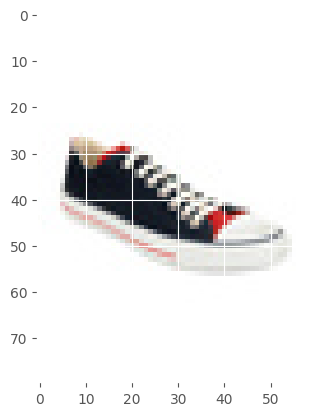

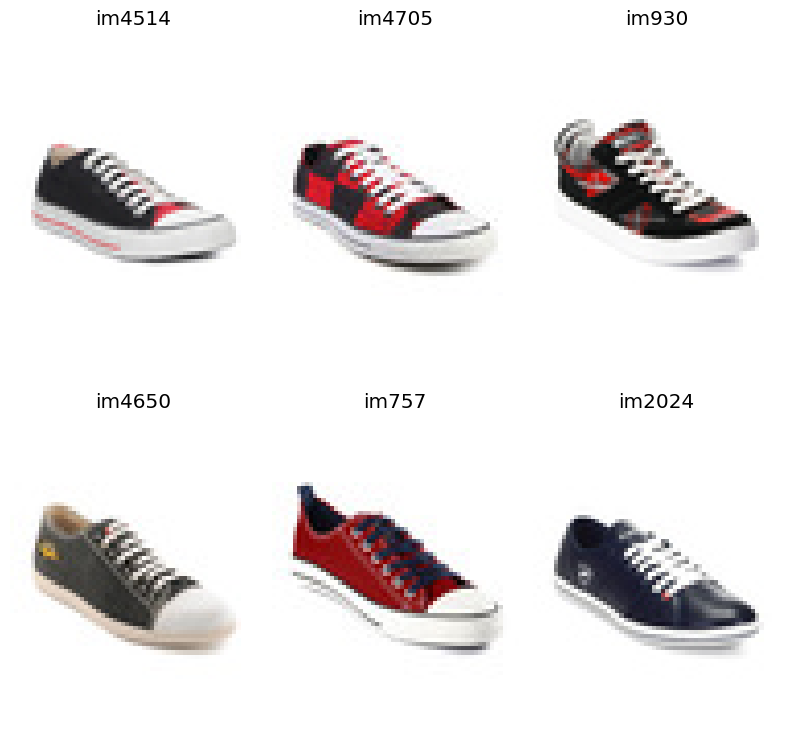

In [34]:
def Rec_viz_image(input_image_id):
    # Getting recommendations
    similar_indices, similarity_scores = recommend_images(input_image_id, df, top_n=6)

    # Printing the similarity scores
    print(similarity_scores)

    # Plotting the image of the item requested by the user
    input_image = load_image(df.iloc[input_image_id].image)
    plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))

    # Generating a dictionary of {index, image} for similar images
    figures = {'im' + str(i): load_image(df.iloc[i].image) for i in similar_indices}

    # Plotting the similar images in a figure, with 2 rows and 3 columns
    show_images_grid(figures, 2, 3)

# Sample usage
Rec_viz_image(3820)


In [35]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2023-12-16 01:54:30--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 52.202.168.65, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  5.15MB/s    in 2.6s    

2023-12-16 01:54:34 (5.15 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [36]:
! /content/ngrok authtoken 2ZTic5usQOzcSIWeBwWH3eeh0dy_6GDzyLRgpaQJRn2ybpFsi

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [37]:
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

Enter the URL: https://m.media-amazon.com/images/W/MEDIAX_792452-T2/images/I/51e8XU5OkKL._AC_UY1000_.jpg
4024    0.809594
4329    0.808915
2041    0.808282
2358    0.803033
3761    0.801640
Name: Score, dtype: float64
4024    16155.jpg
Name: image, dtype: object
4329    30261.jpg
Name: image, dtype: object
2041    23679.jpg
Name: image, dtype: object
2358    17822.jpg
Name: image, dtype: object
3761    16152.jpg
Name: image, dtype: object


['16155.jpg', '30261.jpg', '23679.jpg', '17822.jpg', '16152.jpg']

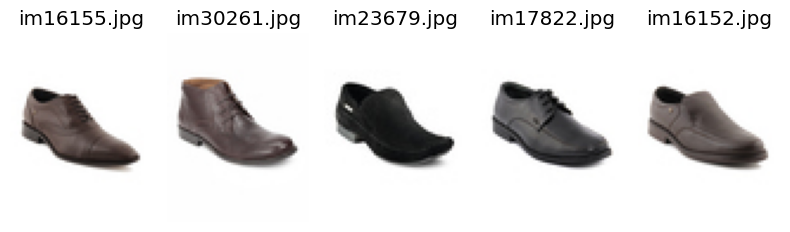

In [38]:
import requests
import io

def recm_user_input(url):
    try:
        # Download the image from the URL
        response = requests.get(url)
        img = Image.open(io.BytesIO(response.content)).convert('RGB')

        # Apply the image transformations
        t_img = Variable(image_transforms(img).unsqueeze(0))

        # Rest of the code
        embeddings = torch.zeros(512)

        def select_d(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))

        hlayer = selected_layer.register_forward_hook(select_d)
        pretrained_resnet(t_img)
        hlayer.remove()
        emb = embeddings

        cs = cosine_similarity(emb.unsqueeze(0), df_embs)
        cs_list = list(flatten(cs))
        cs_df = pd.DataFrame(cs_list, columns=['Score'])
        cs_df = cs_df.sort_values(by=['Score'], ascending=False)

        print(cs_df['Score'][:5])

        top5 = cs_df[:5].index
        top5 = list(flatten(top5))
        images_list = []

        for i in top5:
            image_id = df[df.index == i]['image']
            print(image_id)
            images_list.append(image_id)

        images_list = list(flatten(images_list))

        figures = {'im' + str(i): Image.open('/content/myntradataset/images/' + i) for i in images_list}
        fig, axes = plt.subplots(1, 5, figsize=(8, 8))

        for index, name in enumerate(figures):
            axes.ravel()[index].imshow(figures[name])
            axes.ravel()[index].set_title(name)
            axes.ravel()[index].set_axis_off()

        plt.tight_layout()
        return(images_list)

    except Exception as e:
        print("Error:", str(e))

# Example usage with a URL
input_url = input("Enter the URL: ")
recm_user_input(input_url)


In [54]:
!mkdir templates

mkdir: cannot create directory ‘templates’: File exists


In [55]:
# Create 'index.html' template
with open('templates/index.html', 'w') as file:
    file.write('''
<!DOCTYPE html>
<html lang="en">
<head>
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css">
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Fashion Recommendation</title>
</head>
<body class="bg-light">
    <div class="container mt-5">
        <h1 class="text-center">Welcome to the Fashion Recommender!</h1>
        <form action="/recommendation" method="post" class="mt-4">
        <label for="image_url">Enter Image URL:</label>
        <input type="text" id="image_url" name="image_url" required>
        <button type="submit">Get Recommendation</button>
    </form>
</body>
</html>
''')


In [56]:
# Route for the main page
@app.route('/')
def index():
    return render_template('index.html')

In [57]:
# Route for displaying recommendations
@app.route('/recommendation', methods=['POST'])
def show_recommendation():
    try:
        url = request.form['image_url']
        images_list = recm_user_input(url)
        return render_template('result.html', images_list=images_list)
    except Exception as e:
        error_message = "Error: " + str(e)
        return render_template('error.html', error_message=error_message)

In [58]:
# Create 'error.html' template
with open('templates/error.html', 'w') as file:
    file.write('''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Error</title>
</head>
<body>
    <h1>Error</h1>
    <p>{{ error_message }}</p>
</body>
</html>
''')


In [59]:
# Create 'result.html' template with Bootstrap styling
with open('templates/result.html', 'w') as file:
    file.write('''
<!DOCTYPE html>
<html lang="en">
<head>
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css">
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Recommendation Result</title>
    <style>
        body {
            background-color: #f8f9fa;
        }

        .container {
            max-width: 800px;
            margin: 20px auto;
        }

        h1 {
            color: #007bff;
            text-align: center;
        }

        .result-card {
            margin-bottom: 20px;
            border: 1px solid #ddd;
            border-radius: 8px;
            overflow: hidden;
            box-shadow: 0 0 8px rgba(0, 0, 0, 0.1);
        }

        .result-card img {
            width: 100%;
            height: auto;
            border-radius: 8px 8px 0 0;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Top 5 Recommendations</h1>
        <div class="row">
            {% for image_id in images_list %}
                <div class="col-md-6">
                    <div class="result-card">
                        <img src="{{ url_for('static', filename='/content/images/' + image_id) }}" alt="{{ image_id }}">
                    </div>
                </div>
            {% endfor %}
        </div>
    </div>
</body>
</html>
''')


In [ ]:
if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://fc33-34-143-177-159.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 22:26:42] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 22:26:43] "GET /favicon.ico HTTP/1.1" 404 -
